In [98]:
# !pip install networkx
# !pip install matplotlib
# !pip install numpy
# !pip install timeit

In [99]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

cmap = plt.get_cmap('tab20')

In [102]:
class Leiden:
    

    def __init__(self, G):
        self.init_G= G
        self.init_label= {node:i for i,node in enumerate(self.init_G.nodes())}
        self.dict_init={i:i for i in range(len(self.init_G.nodes()))}
        self.G = G
        self.label = {node:i for i,node in enumerate(self.G.nodes())}
        self.old_label = {}
        self.label_num = len(self.G.nodes())
        self.max_iter = 100
        self.iter = 0
        self.pile = [node for node in self.G.nodes()]

    def get_label_num(self):
        return np.unique(list(self.label.values())).shape[0]
            
    def draw_graph(self,label=False):
        map= [v for _,v in self.label.items()]
        u=np.unique(map)
        fixed_map=[np.where(u==i)[0][0] for i in map]
        node_cmap = [cmap(v) for v in fixed_map]
        
        pos = nx.spring_layout(self.G,seed=40)
        # add label too nodes
        if label:
            labels = {node:node for node in self.G.nodes()}
            nx.draw_networkx_labels(self.G, pos, labels, font_size=10)
            
        nx.draw(self.G, pos, node_size = 75, alpha = 0.8, node_color=node_cmap)
        plt.show()

    def delta_madularity(self,node,community):

        mod=self.get_G_modularity()
       
        old_com=self.label[node]
        self.label[node] = community
        new_mod=self.get_G_modularity()
        self.label[node]= old_com
    
        return new_mod-mod
            
    def move_node_fast(self,draw=False):
        self.old_label = self.label.copy()
        if draw:
            self.draw_graph()
        while len(self.pile) > 0:
            node = self.pile.pop(0)
            best_community = self.label[node]
            best_delta_mod = 0
            neighbors = self.G.neighbors(node)
            for neighbor in neighbors:
                community = self.label[neighbor]
                delta_mod = self.delta_madularity(node,community)
                if delta_mod > best_delta_mod:
                    best_community = community
                    best_delta_mod = delta_mod
            if best_community != self.label[node]:
                self.label[node] = best_community
                for neighbor in neighbors:
                    if neighbor not in self.pile and self.label[neighbor] != best_community:
                        self.pile.append(neighbor)
        if draw:
            self.draw_graph()
            
        self.init_label={node:self.label[self.dict_init[node]] for node in self.init_G.nodes()}

    def aggregation(self,draw=False):
        communities = self.get_communities()
        agg_G = nx.Graph()
        for C in communities:
            agg_G.add_node(C)
        for u, v in self.G.edges():
            for C in communities:
                if u in communities.get(C):
                    for D in communities:
                        if v in communities.get(D):
                            agg_G.add_edge(C, D)
                            break
                    break
        
        dict_init={node:self.label[self.dict_init[node]] for node in self.init_G.nodes()}
        self.dict_init=dict_init
        self.G = agg_G
        self.label = {node:i for i,node in enumerate(self.G.nodes())}
        self.label_num = len(self.G.nodes())
        self.pile = [node for node in self.G.nodes()]

    def run(self,draw=False):
        while self.iter < self.max_iter:
            self.move_node_fast(draw)
            if self.label == self.old_label:
                break
            self.aggregation(draw)
            self.iter += 1

    def get_communities(self):
        comm_dict = {}
        for node,comm in self.label.items():
            if comm in comm_dict:
                comm_dict[comm].add(node)
            else:
                comm_dict[comm] = {node}
        return comm_dict

    def get_init_communities(self):
        comm_dict = {}
        for node,comm in self.init_label.items():
            if comm in comm_dict:
                comm_dict[comm].add(node)
            else:
                comm_dict[comm] = {node}
        return comm_dict

    def get_G_modularity(self):
        return nx.algorithms.community.modularity(self.G, self.get_communities().values())

    def get_init_G_modularity(self):
        comm_dict = {}
        for node,comm in self.init_label.items():
            if comm in comm_dict:
                comm_dict[comm].add(node)
            else:
                comm_dict[comm] = {node}
        return nx.algorithms.community.modularity(self.init_G, comm_dict.values())
    

   

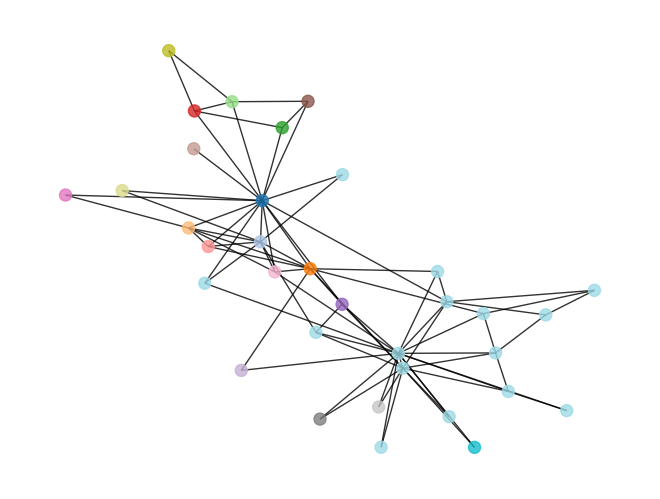

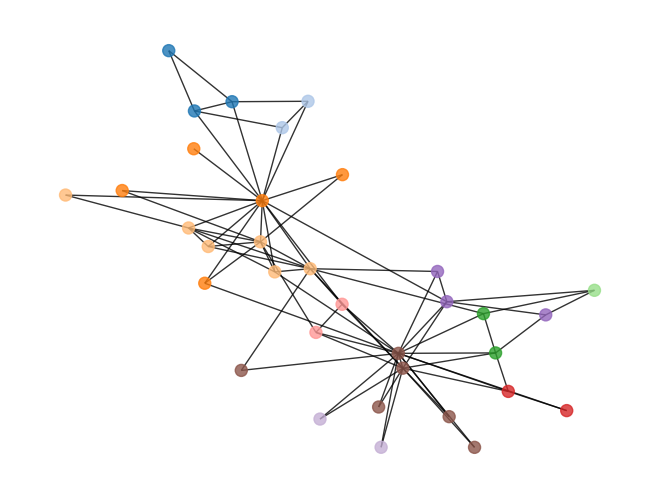

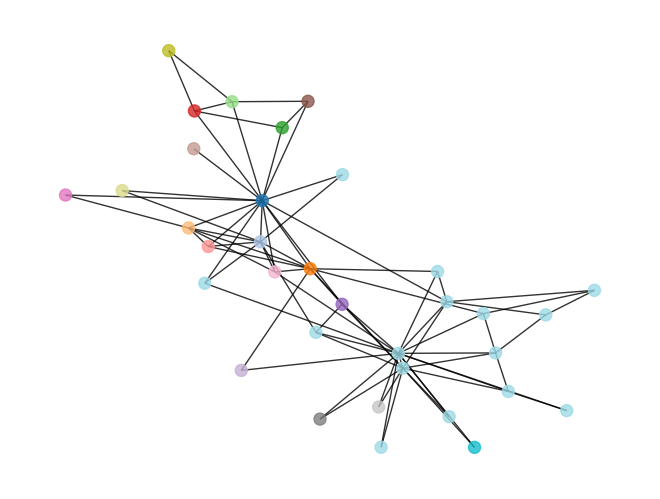

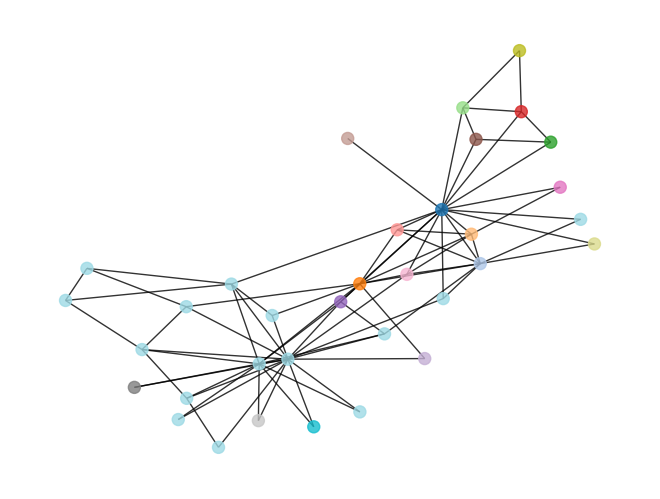

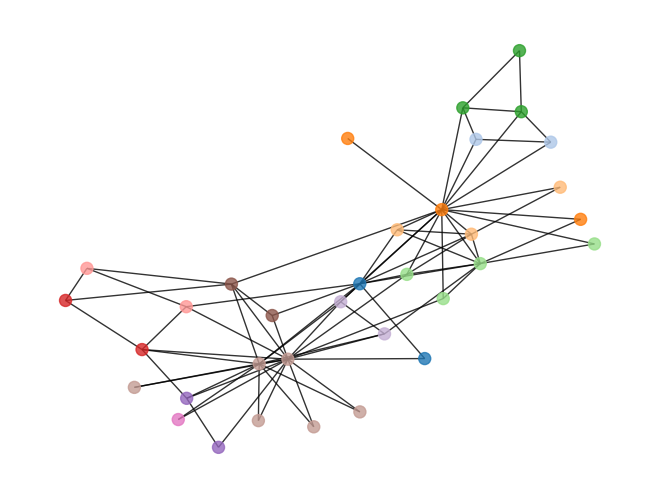

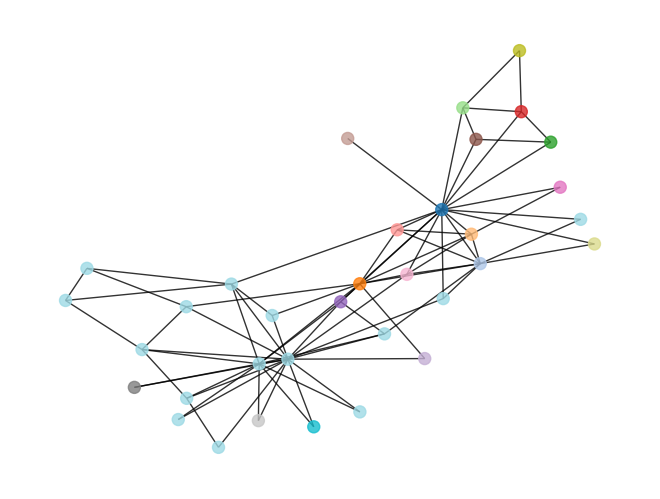

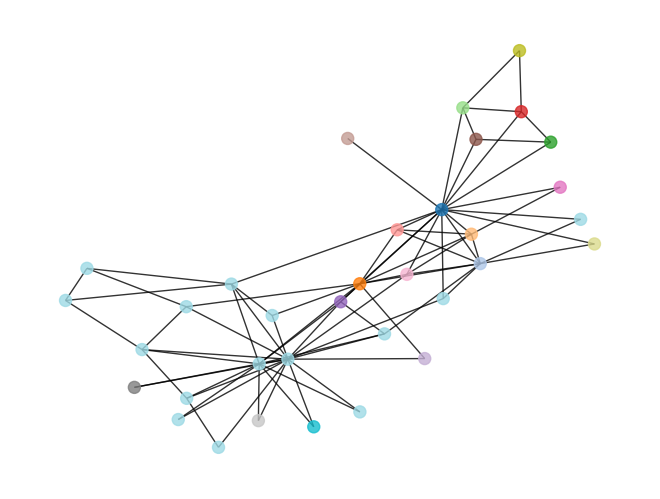

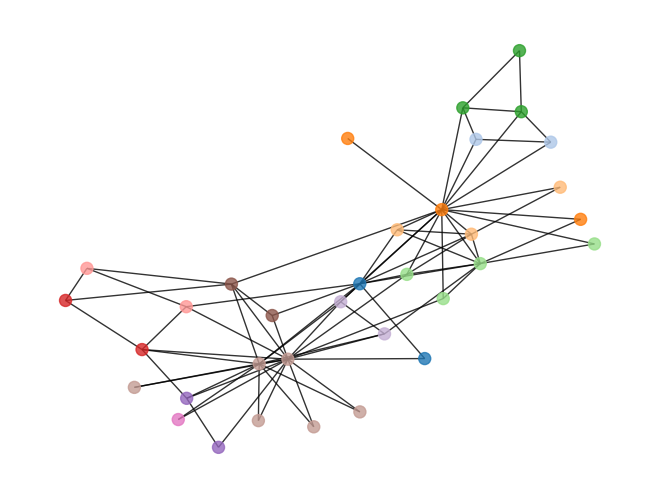

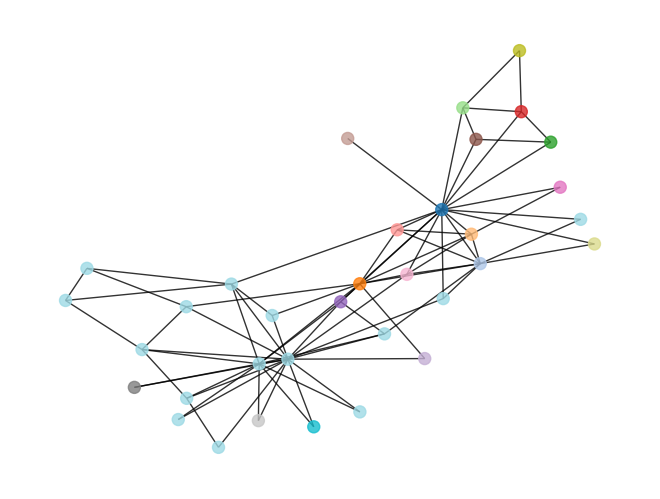

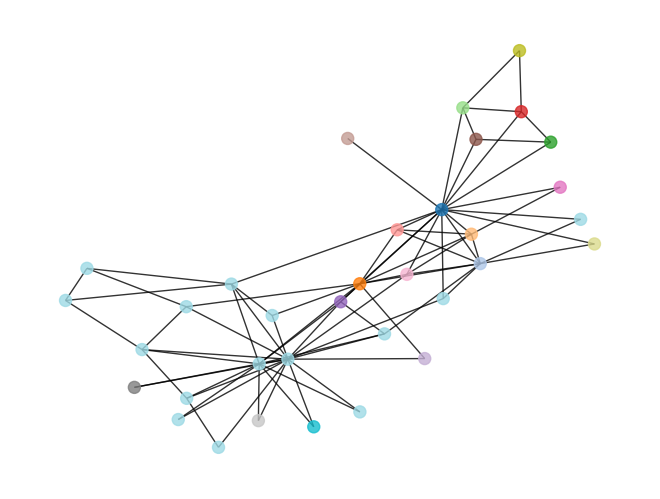

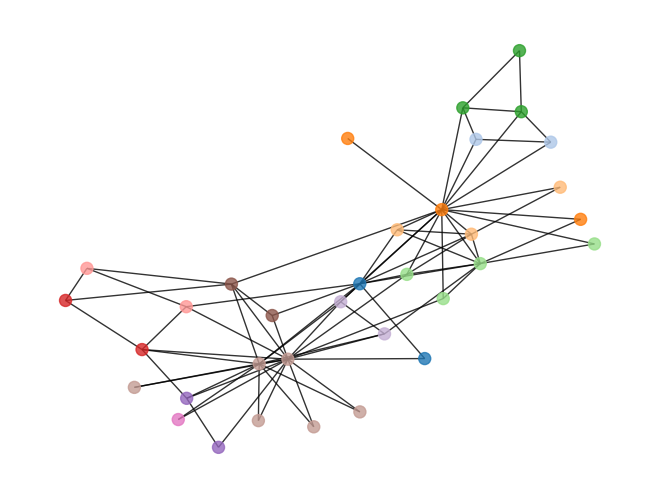

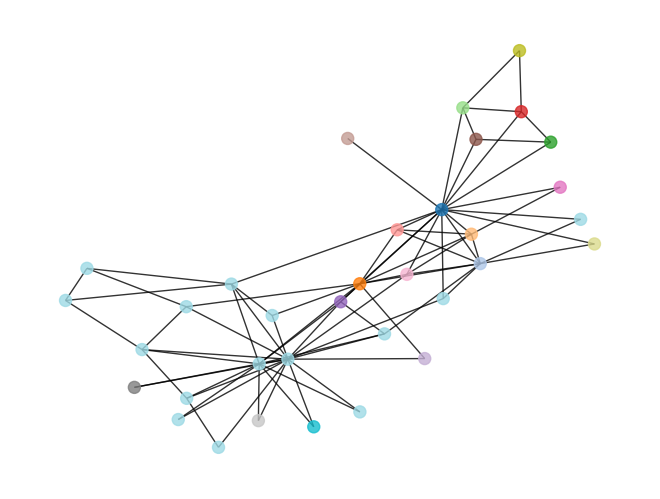

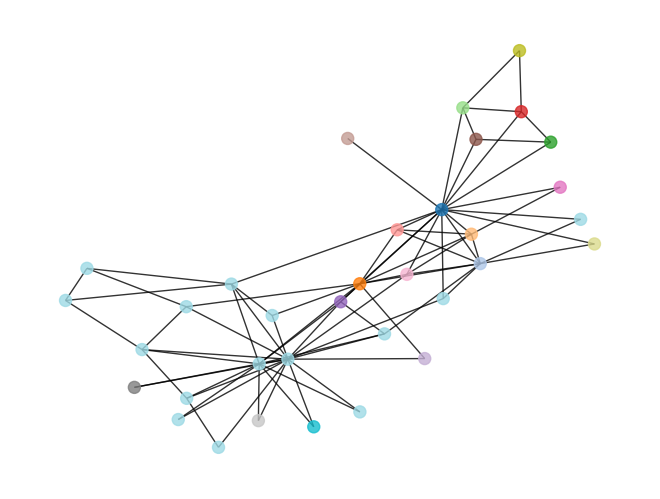

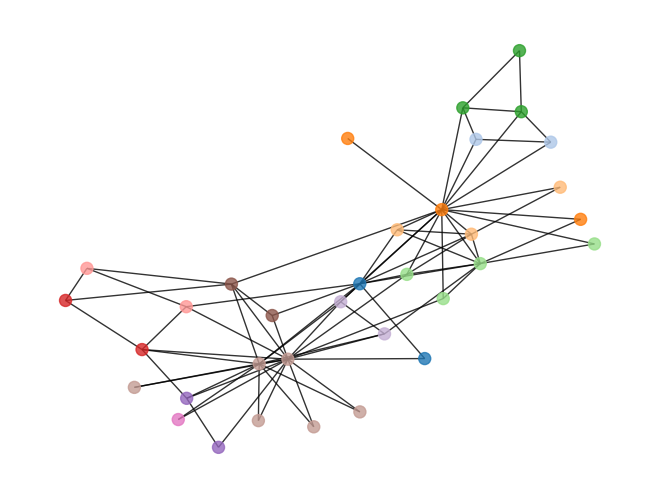

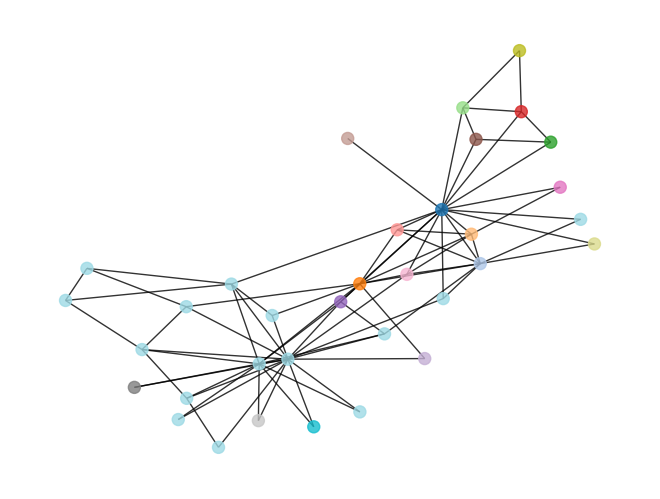

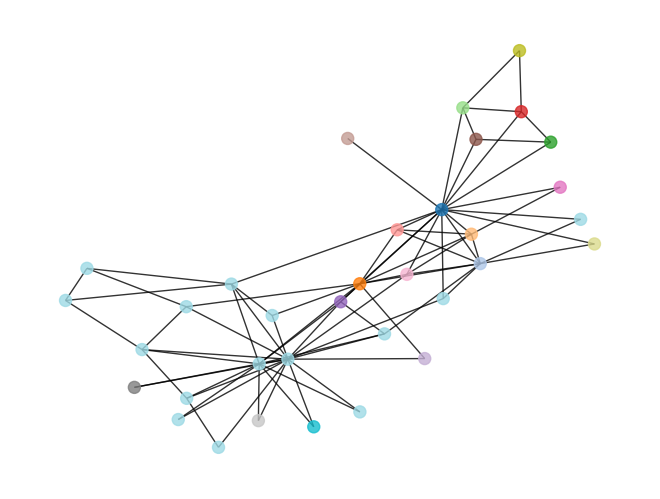

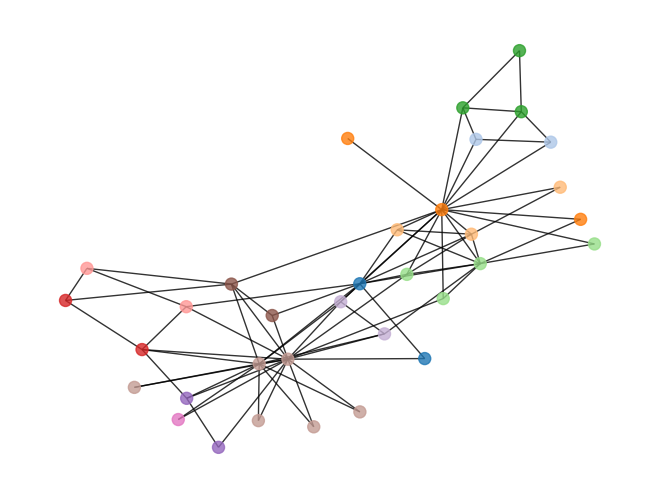

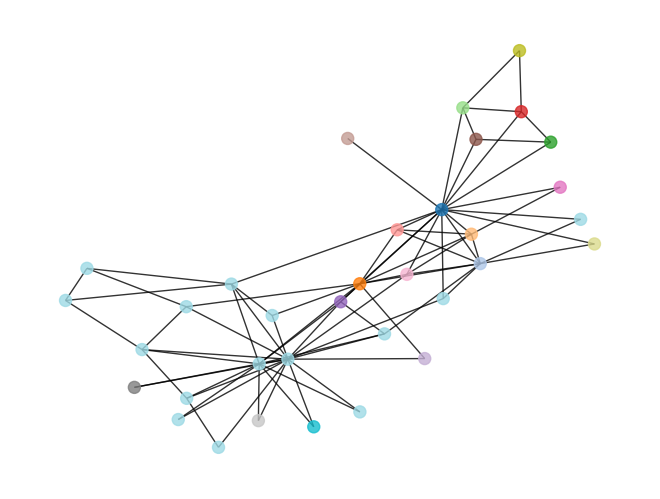

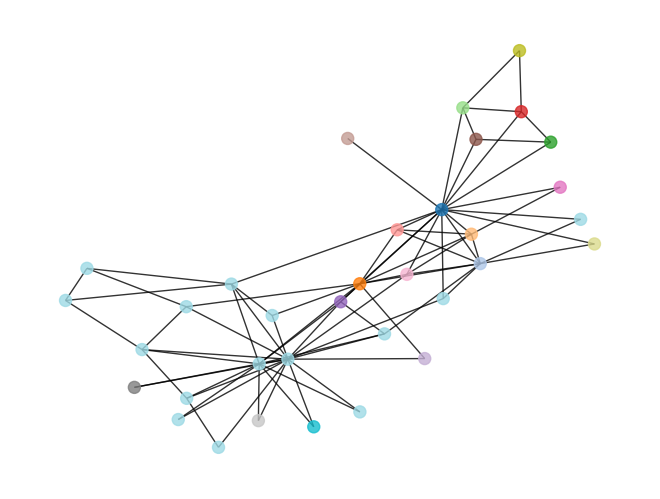

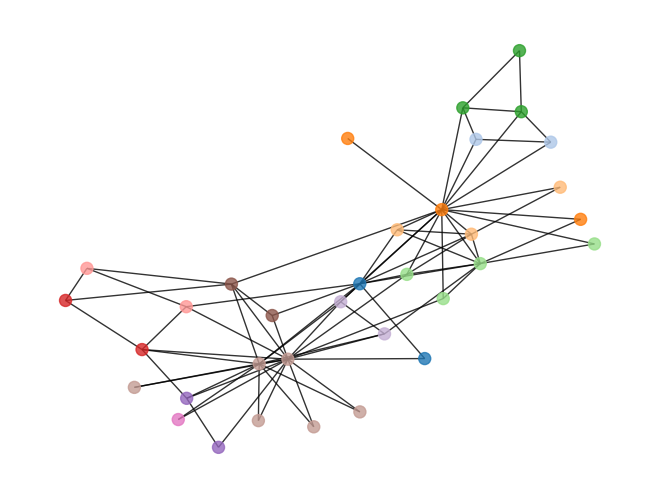

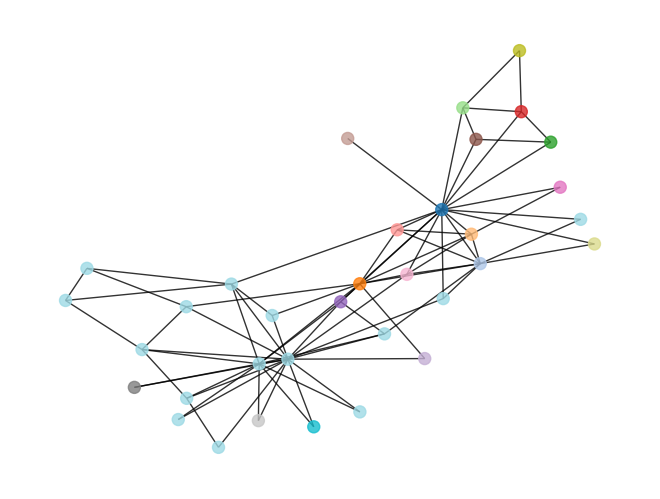

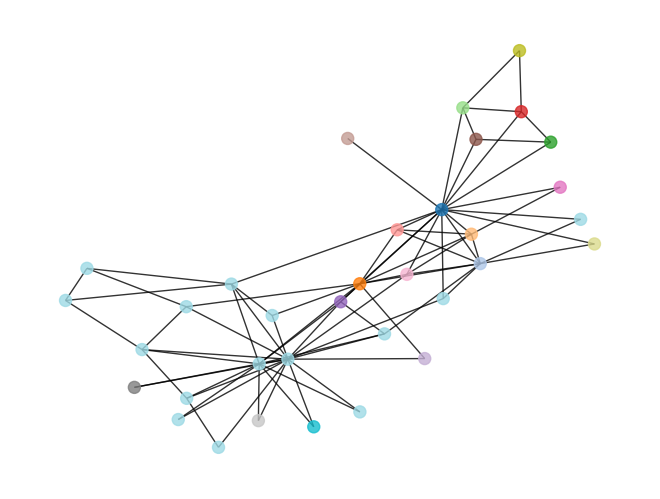

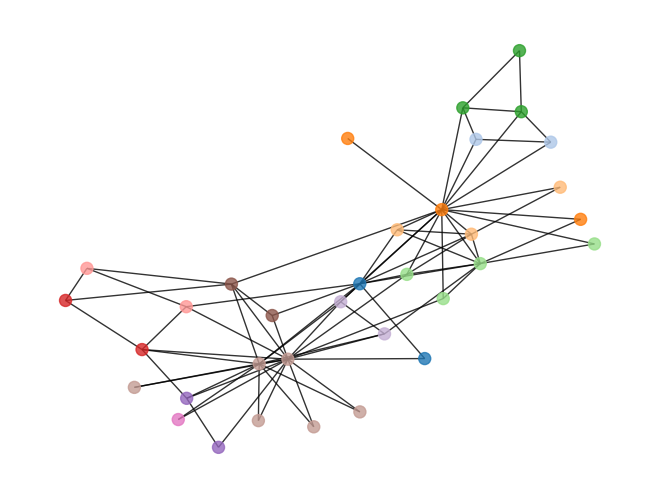

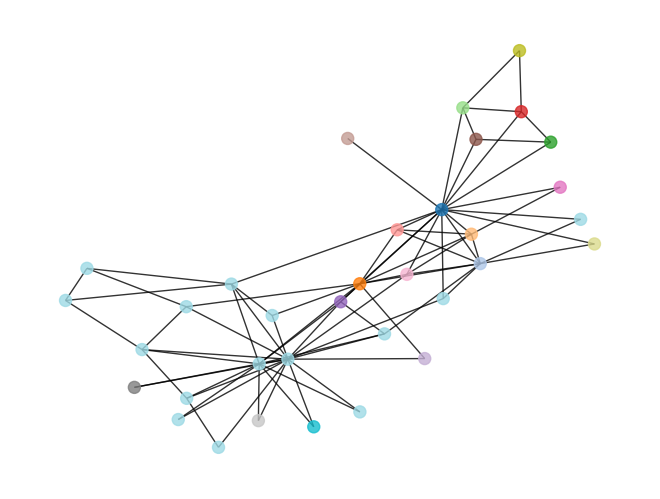

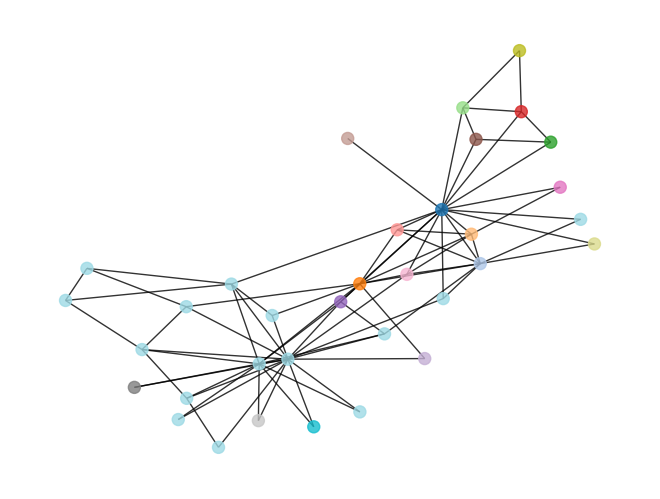

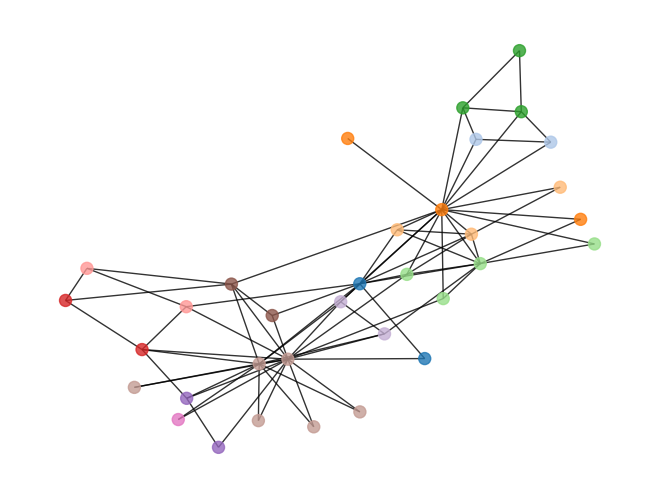

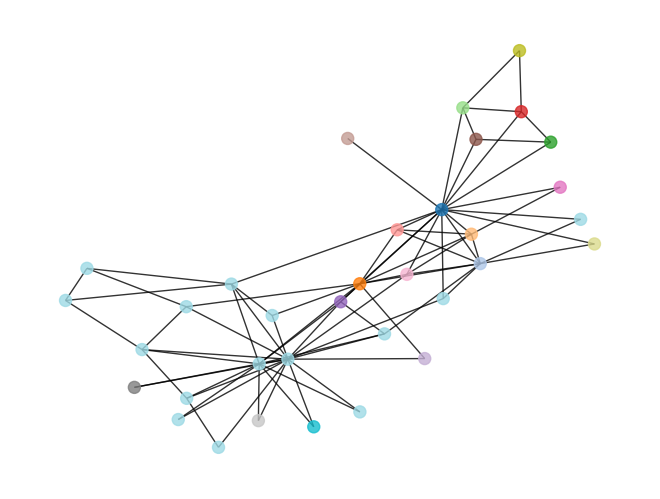

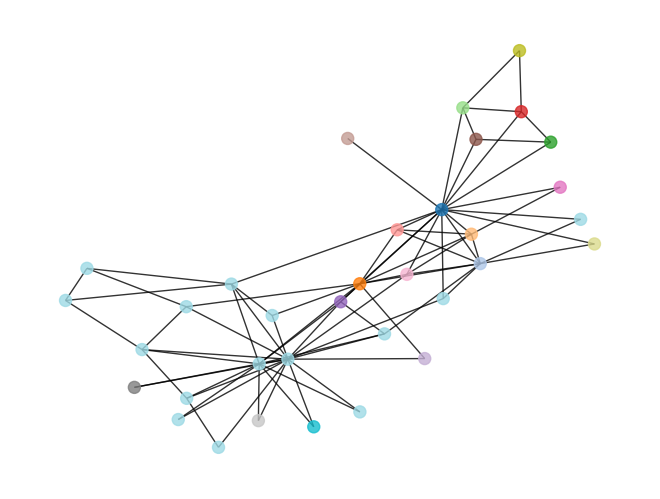

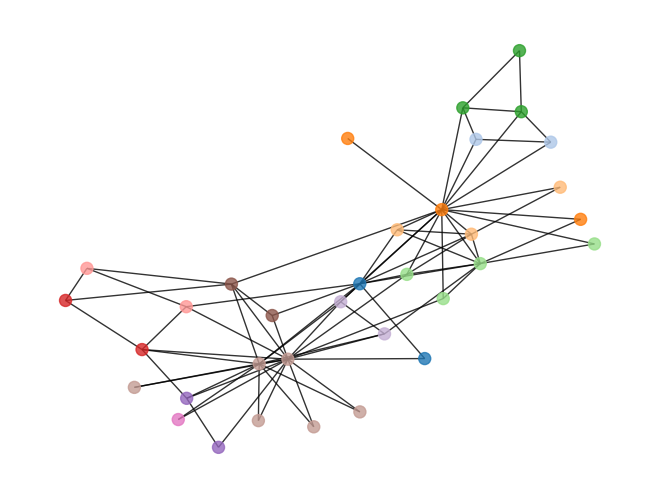

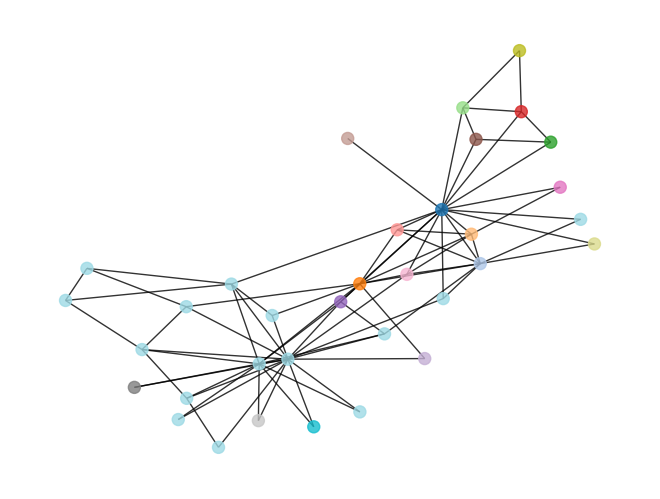

KeyboardInterrupt: 

In [103]:
G=nx.karate_club_graph()
algorithm = Leiden(G)

start = timeit.default_timer()
algorithm.run(draw=True)
end = timeit.default_timer()
print("number of communities:",algorithm.get_label_num())
print("time:",end - start)
print("modularity:",algorithm.get_init_G_modularity())